In [84]:
import pandas as pd
import numpy as np
import seaborn as sns
import matplotlib.pyplot as plt
from sklearn.preprocessing import OneHotEncoder
from sklearn.model_selection import train_test_split
from sklearn.tree import DecisionTreeClassifier
from sklearn.neighbors import KNeighborsClassifier
from sklearn.model_selection import validation_curve, learning_curve, cross_validate
from six import StringIO
from IPython.display import Image  
from sklearn.tree import export_graphviz
import pydotplus

# Preprocessing and EDA

In [5]:
cars = pd.read_csv('data/car.data', names=['buying', 'maint', 'doors', 'persons', 'lug_boot', 'safety', 'target'])

In [6]:
cars.head()

,buying,maint,doors,persons,lug_boot,safety,target
0,vhigh,vhigh,2,2,small,low,unacc
1,vhigh,vhigh,2,2,small,med,unacc
2,vhigh,vhigh,2,2,small,high,unacc
3,vhigh,vhigh,2,2,med,low,unacc
4,vhigh,vhigh,2,2,med,med,unacc


In [7]:
cars['target'].value_counts()

unacc    1210
acc       384
good       69
vgood      65
Name: target, dtype: int64

In [8]:
cars['target'] = cars['target'].apply(lambda x: 0 if x == 'unacc' else 1)

In [9]:
cars['target'].value_counts()

0    1210
1     518
Name: target, dtype: int64

In [10]:
cars.describe(include='all')

,buying,maint,doors,persons,lug_boot,safety,target
count,1728,1728,1728,1728,1728,1728,1728.000000
unique,4,4,4,3,3,3,NaN
top,vhigh,vhigh,2,2,small,low,NaN
freq,432,432,432,576,576,576,NaN
mean,NaN,NaN,NaN,NaN,NaN,NaN,0.299769
std,NaN,NaN,NaN,NaN,NaN,NaN,0.458289
min,NaN,NaN,NaN,NaN,NaN,NaN,0.000000
25%,NaN,NaN,NaN,NaN,NaN,NaN,0.000000
50%,NaN,NaN,NaN,NaN,NaN,NaN,0.000000
75%,NaN,NaN,NaN,NaN,NaN,NaN,1.000000


<AxesSubplot: xlabel='buying', ylabel='count'>

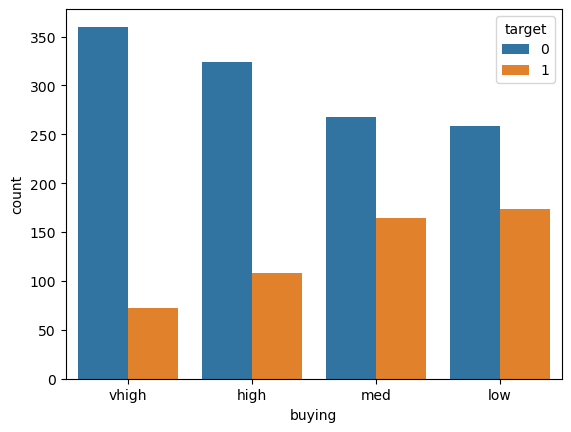

In [11]:
sns.countplot(data=cars, x='buying', hue = 'target')

<AxesSubplot: xlabel='maint', ylabel='count'>

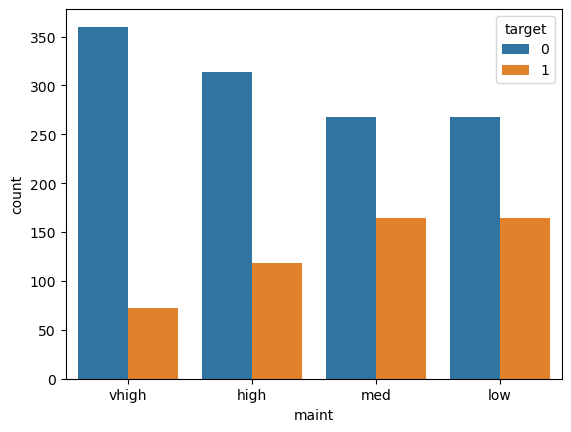

In [12]:
sns.countplot(data=cars, x='maint', hue = 'target')

<AxesSubplot: xlabel='doors', ylabel='count'>

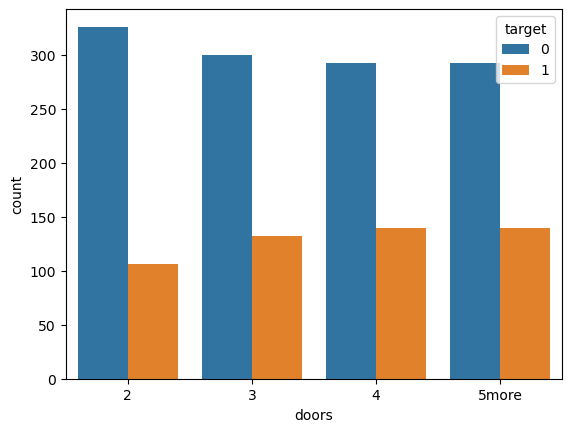

In [13]:
sns.countplot(data=cars, x='doors', hue = 'target')

<AxesSubplot: xlabel='persons', ylabel='count'>

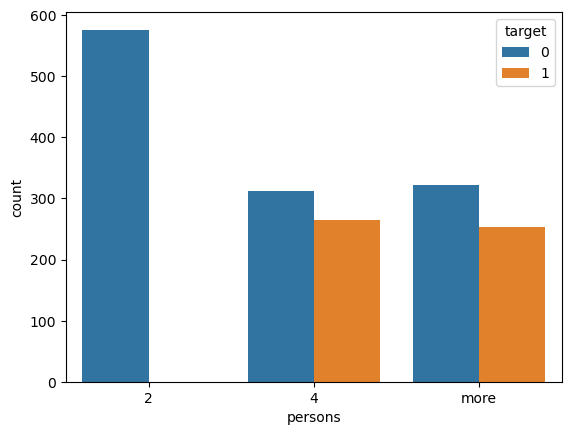

In [14]:
sns.countplot(data=cars, x='persons', hue = 'target')

<AxesSubplot: xlabel='lug_boot', ylabel='count'>

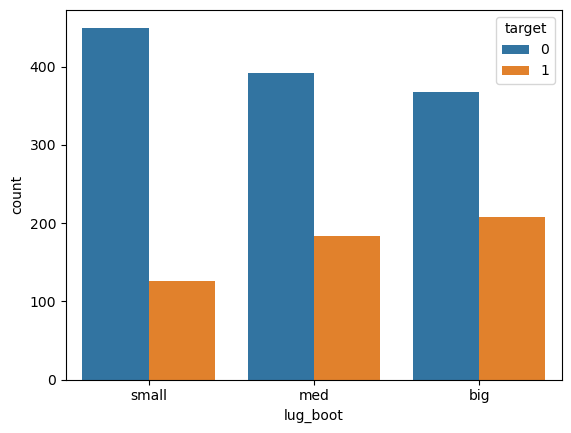

In [15]:
sns.countplot(data=cars, x='lug_boot', hue = 'target')

<AxesSubplot: xlabel='safety', ylabel='count'>

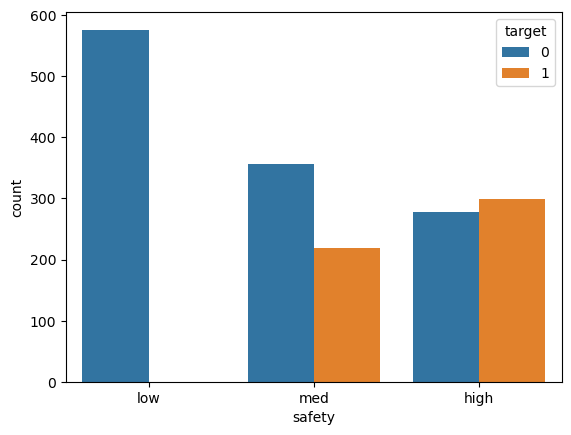

In [16]:
sns.countplot(data=cars, x='safety', hue = 'target')

In [17]:
X = cars['target']

skencoder = OneHotEncoder(drop='first',sparse_output=False)
skencoder.set_output(transform="pandas")
ohe_cars = skencoder.fit_transform(cars.loc[:,['buying', 'maint', 'doors', 'persons', 'lug_boot', 'safety']])
ohe_cars['target'] = X

In [18]:
ohe_cars.head()

,buying_low,buying_med,buying_vhigh,maint_low,maint_med,maint_vhigh,doors_3,doors_4,doors_5more,persons_4,persons_more,lug_boot_med,lug_boot_small,safety_low,safety_med,target
0,0.0,0.0,1.0,0.0,0.0,1.0,0.0,0.0,0.0,0.0,0.0,0.0,1.0,1.0,0.0,0
1,0.0,0.0,1.0,0.0,0.0,1.0,0.0,0.0,0.0,0.0,0.0,0.0,1.0,0.0,1.0,0
2,0.0,0.0,1.0,0.0,0.0,1.0,0.0,0.0,0.0,0.0,0.0,0.0,1.0,0.0,0.0,0
3,0.0,0.0,1.0,0.0,0.0,1.0,0.0,0.0,0.0,0.0,0.0,1.0,0.0,1.0,0.0,0
4,0.0,0.0,1.0,0.0,0.0,1.0,0.0,0.0,0.0,0.0,0.0,1.0,0.0,0.0,1.0,0


In [19]:
ohe_cars['target'].value_counts()

0    1210
1     518
Name: target, dtype: int64

In [20]:
cars_x = ohe_cars.loc[:, ohe_cars.columns != 'target']
cars_y = ohe_cars['target']

X_train, X_test, y_train, y_test = train_test_split(cars_x, cars_y, test_size = 0.2)

# Model Training and Experimentation

In [64]:
_random_state = 0

def get_validation_curve(classifier, X, y, param, range_lower, range_upper, step, _scoring):
   param_range = np.arange(range_lower, range_upper, step)

   train_scores, valid_scores = validation_curve(
                                 classifier,
                                 X,
                                 y,
                                 param_name=param,
                                 param_range=param_range,
                                 cv=5,
                                 scoring=_scoring)

   # Calculating mean and standard deviation of training score
   mean_train_score = np.mean(train_scores, axis = 1)
   std_train_score = np.std(train_scores, axis = 1)

   # Calculating mean and standard deviation of testing score
   mean_valid_score = np.mean(valid_scores, axis = 1)
   std_valid_score = np.std(valid_scores, axis = 1)

   # Plot mean accuracy scores for training and testing scores
   fig = plt.figure()
   plt.plot(param_range, mean_train_score,
      label = "Training Score", color = 'b')
   plt.plot(param_range, mean_valid_score,
      label = "Cross Validation Score", color = 'g')

   # Creating the plot
   plt.title(f"Validation Curve with {classifier.__class__.__name__}")
   plt.xlabel(param)
   plt.ylabel(_scoring)
   plt.tight_layout()
   plt.legend(loc = 'best')
   return fig, mean_train_score, mean_valid_score

def cross_validation(model, _X, _y, _cv=5):
   '''Function to perform 5 Folds Cross-Validation
      Parameters
      ----------
   model: Python Class, default=None
            This is the machine learning algorithm to be used for training.
   _X: array
         This is the matrix of features.
   _y: array
         This is the target variable.
   _cv: int, default=5
         Determines the number of folds for cross-validation.
      Returns
      -------
      The function returns a dictionary containing the metrics 'accuracy', 'precision',
      'recall', 'f1' for both training set and validation set.
   '''
   _scoring = ['accuracy', 'precision', 'recall', 'f1']
   results = cross_validate(estimator=model,
                              X=_X,
                              y=_y,
                              cv=_cv,
                              scoring=_scoring,
                              return_train_score=True)
      
   return {"Training Accuracy scores": results['train_accuracy'],
            "Mean Training Accuracy": results['train_accuracy'].mean()*100,
            "Training Precision scores": results['train_precision'],
            "Mean Training Precision": results['train_precision'].mean(),
            "Training Recall scores": results['train_recall'],
            "Mean Training Recall": results['train_recall'].mean(),
            "Training F1 scores": results['train_f1'],
            "Mean Training F1 Score": results['train_f1'].mean(),
            "Validation Accuracy scores": results['test_accuracy'],
            "Mean Validation Accuracy": results['test_accuracy'].mean()*100,
            "Validation Precision scores": results['test_precision'],
            "Mean Validation Precision": results['test_precision'].mean(),
            "Validation Recall scores": results['test_recall'],
            "Mean Validation Recall": results['test_recall'].mean(),
            "Validation F1 scores": results['test_f1'],
            "Mean Validation F1 Score": results['test_f1'].mean()
            }

def plot_cv_result_avg(x_label, y_label, plot_title, train_data, val_data):
   '''Function to plot a grouped bar chart showing the training and validation
      results of the ML model in each fold after applying K-fold cross-validation.
   Parameters
   ----------
   x_label: str, 
      Name of the algorithm used for training e.g 'Decision Tree'
      
   y_label: str, 
      Name of metric being visualized e.g 'Accuracy'
   plot_title: str, 
      This is the title of the plot e.g 'Accuracy Plot'
   
   train_result: list, array
      This is the list containing either training precision, accuracy, or f1 score.
   
   val_result: list, array
      This is the list containing either validation precision, accuracy, or f1 score.
   Returns
   -------
   The function returns a Grouped Barchart showing the training and validation result
   in each fold.
   '''
   
   # Set size of plot
   plt.figure(figsize=(12,6))
   # labels = ["1st Fold", "2nd Fold", "3rd Fold", "4th Fold", "5th Fold"]
   labels = ['avg']
   X_axis = np.arange(len(labels))
   ax = plt.gca()
   plt.ylim(0.40000, 1)
   plt.bar(X_axis-0.2, train_data, 0.4, color='blue', label='Training')
   plt.bar(X_axis+0.2, val_data, 0.4, color='red', label='Validation')
   plt.title(plot_title, fontsize=30)
   plt.xticks(X_axis, labels)
   plt.xlabel(x_label, fontsize=14)
   plt.ylabel(y_label, fontsize=14)
   plt.legend()
   plt.grid(True)
   plt.show()

def plot_cv_result(x_label, y_label, plot_title, train_data, val_data):
   '''Function to plot a grouped bar chart showing the training and validation
      results of the ML model in each fold after applying K-fold cross-validation.
   Parameters
   ----------
   x_label: str, 
      Name of the algorithm used for training e.g 'Decision Tree'
      
   y_label: str, 
      Name of metric being visualized e.g 'Accuracy'
   plot_title: str, 
      This is the title of the plot e.g 'Accuracy Plot'
   
   train_result: list, array
      This is the list containing either training precision, accuracy, or f1 score.
   
   val_result: list, array
      This is the list containing either validation precision, accuracy, or f1 score.
   Returns
   -------
   The function returns a Grouped Barchart showing the training and validation result
   in each fold.
   '''
   
   # Set size of plot
   plt.figure(figsize=(12,6))
   labels = ["1st Fold", "2nd Fold", "3rd Fold", "4th Fold", "5th Fold"]
   X_axis = np.arange(len(labels))
   ax = plt.gca()
   plt.ylim(0.40000, 1)
   plt.bar(X_axis-0.2, train_data, 0.4, color='blue', label='Training')
   plt.bar(X_axis+0.2, val_data, 0.4, color='red', label='Validation')
   plt.title(plot_title, fontsize=30)
   plt.xticks(X_axis, labels)
   plt.xlabel(x_label, fontsize=14)
   plt.ylabel(y_label, fontsize=14)
   plt.legend()
   plt.grid(True)
   plt.show()

## Decision Tree

### Information Gain

#### Entropy

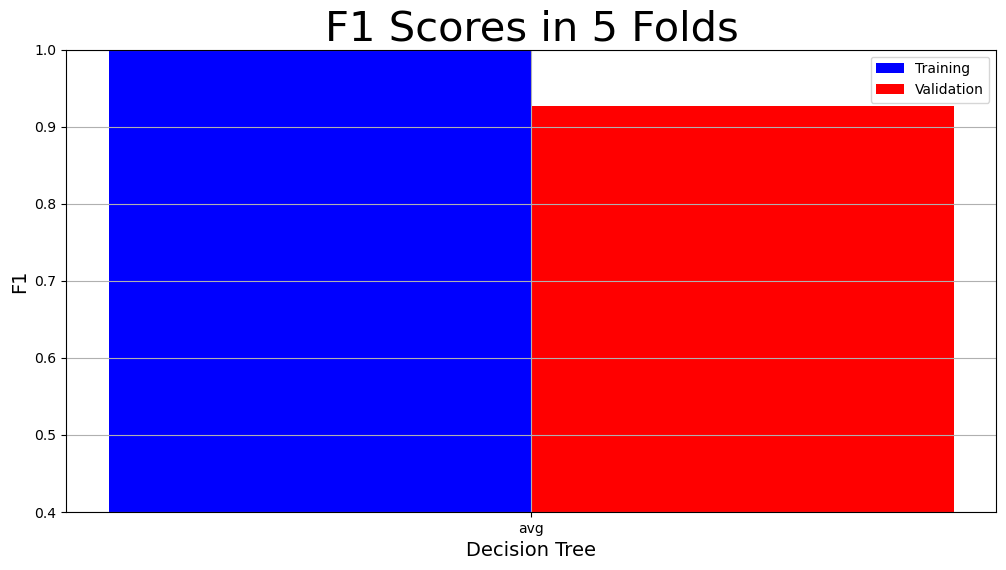

Train F1 mean:  1.0
Validation F1 mean:  0.9272951325320768


In [65]:
decision_tree_model = DecisionTreeClassifier(criterion="entropy",
                                     random_state=_random_state)
decision_tree_result = cross_validation(decision_tree_model, X_train, y_train, 5)

# Plot F1 Result
model_name = "Decision Tree"
plot_cv_result_avg(model_name,
            "F1",
            "F1 Scores in 5 Folds",
            decision_tree_result["Training F1 scores"].mean(),
            decision_tree_result["Validation F1 scores"].mean())

print("Train F1 mean: ", decision_tree_result["Training F1 scores"].mean())
print("Validation F1 mean: ", decision_tree_result["Validation F1 scores"].mean())

#### Gini

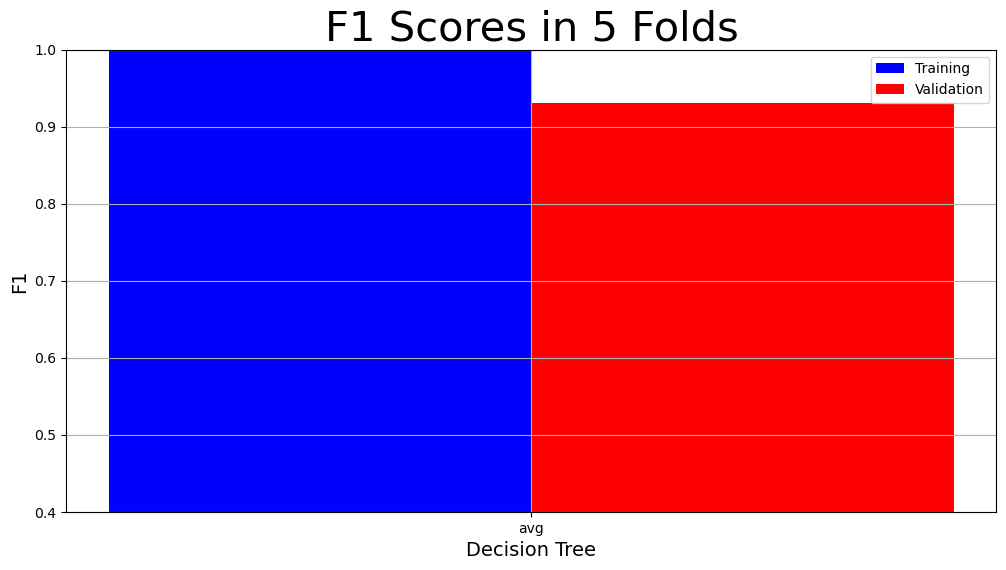

Train F1 mean:  1.0
Validation F1 mean:  0.9311408339116145


In [66]:
decision_tree_model = DecisionTreeClassifier(criterion="gini",
                                     random_state=_random_state)
decision_tree_result = cross_validation(decision_tree_model, X_train, y_train, 5)

# Plot F1 Result
model_name = "Decision Tree"
plot_cv_result_avg(model_name,
            "F1",
            "F1 Scores in 5 Folds",
            decision_tree_result["Training F1 scores"].mean(),
            decision_tree_result["Validation F1 scores"].mean())

print("Train F1 mean: ", decision_tree_result["Training F1 scores"].mean())
print("Validation F1 mean: ", decision_tree_result["Validation F1 scores"].mean())

#### Log Loss

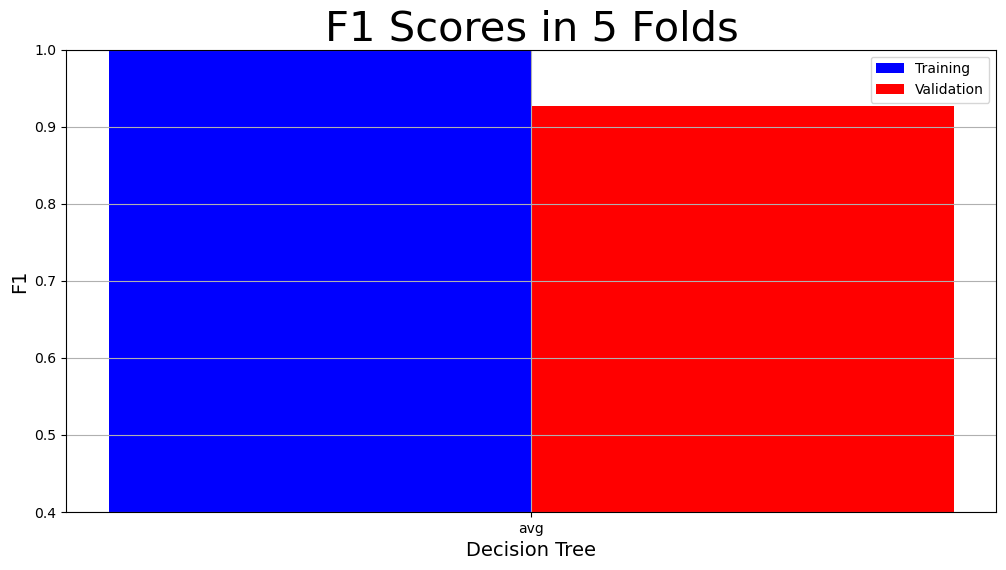

Train F1 mean:  1.0
Validation F1 mean:  0.9272951325320768


In [67]:
decision_tree_model = DecisionTreeClassifier(criterion="log_loss",
                                     random_state=_random_state)
decision_tree_result = cross_validation(decision_tree_model, X_train, y_train, 5)

# Plot F1 Result
model_name = "Decision Tree"
plot_cv_result_avg(model_name,
            "F1",
            "F1 Scores in 5 Folds",
            decision_tree_result["Training F1 scores"].mean(),
            decision_tree_result["Validation F1 scores"].mean())

print("Train F1 mean: ", decision_tree_result["Training F1 scores"].mean())
print("Validation F1 mean: ", decision_tree_result["Validation F1 scores"].mean())

### Validation & Learning Curves

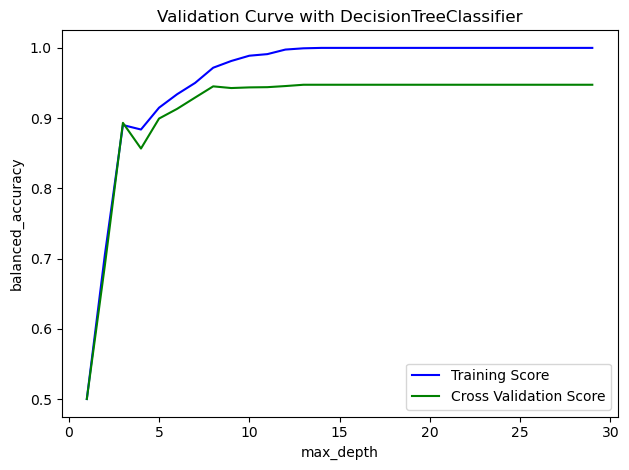

Indices: [28 19 12]
Values: [0.94751341 0.94751341 0.94751341]


In [70]:
f, train_scores, valid_scores = get_validation_curve(DecisionTreeClassifier(random_state=_random_state), X_train, y_train, "max_depth", 1, 30, 1, 'balanced_accuracy')
plt.show()
x = np.argsort(valid_scores)[::-1][:3]
print("Indices:",x)

# Getting N maximum values
print("Values:",valid_scores[x])

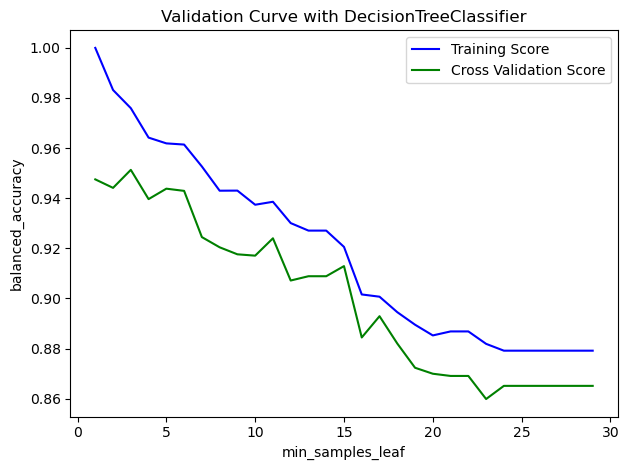

Indices: [2 0 1]
Values: [0.95131615 0.94751341 0.94412487]


In [72]:
f, train_scores, valid_scores = get_validation_curve(DecisionTreeClassifier(random_state=_random_state), X_train, y_train, "min_samples_leaf", 1, 30, 1, 'balanced_accuracy')
plt.show()
x = np.argsort(valid_scores)[::-1][:3]
print("Indices:",x)

# Getting N maximum values
print("Values:",valid_scores[x])

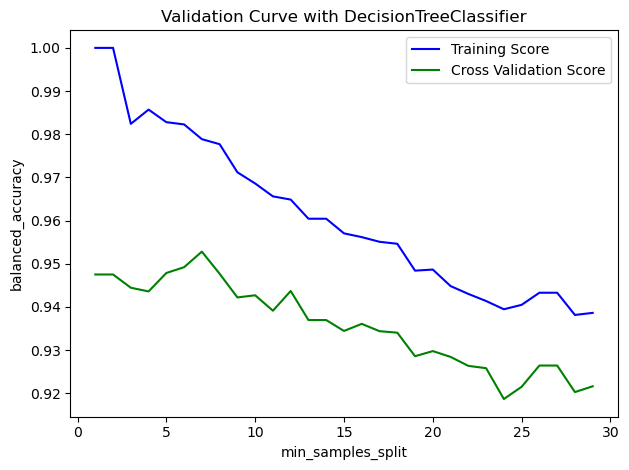

Indices: [6 5 4]
Values: [0.95280425 0.94920414 0.94785945]


In [73]:
f, train_scores, valid_scores = get_validation_curve(DecisionTreeClassifier(random_state=_random_state), X_train, y_train, "min_samples_split", 1, 30, 1, 'balanced_accuracy')
plt.show()
x = np.argsort(valid_scores)[::-1][:3]
print("Indices:",x)

# Getting N maximum values
print("Values:",valid_scores[x])

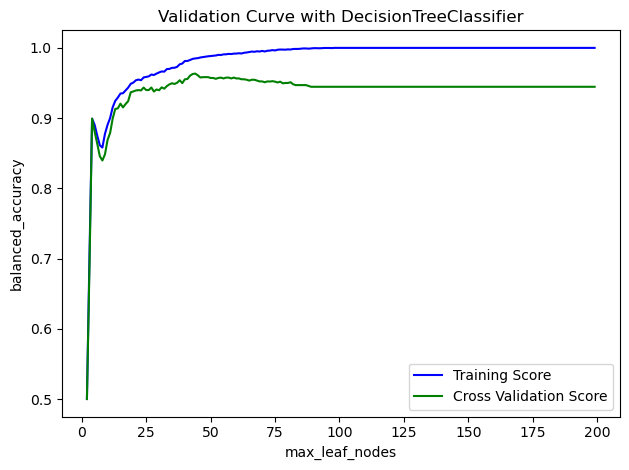

Indices: [ 0 43 42]
Values: [       nan 0.96342084 0.96276554]


In [74]:
f, train_scores, valid_scores = get_validation_curve(DecisionTreeClassifier(random_state=_random_state), X_train, y_train, "max_leaf_nodes", 1, 200, 1, 'balanced_accuracy')
plt.show()
x = np.argsort(valid_scores)[::-1][:3]
print("Indices:",x)

# Getting N maximum values
print("Values:",valid_scores[x])

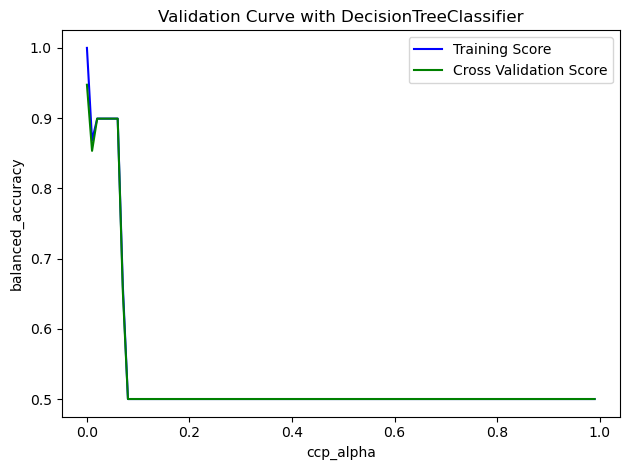

Indices: [0 6 2]
Values: [0.94751341 0.89926058 0.89926058]


In [75]:
f, train_scores, valid_scores = get_validation_curve(DecisionTreeClassifier(random_state=_random_state), X_train, y_train, "ccp_alpha", 0, 1, 0.01, 'balanced_accuracy')
plt.show()
x = np.argsort(valid_scores)[::-1][:3]
print("Indices:",x)

# Getting N maximum values
print("Values:",valid_scores[x])

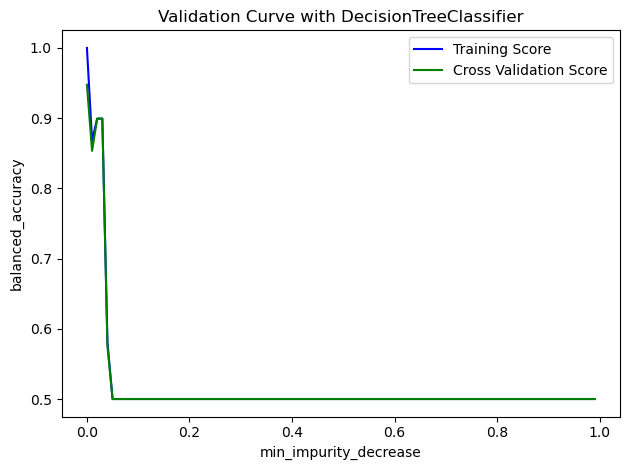

Indices: [0 2 3]
Values: [0.94751341 0.89926058 0.89926058]


In [76]:
f, train_scores, valid_scores = get_validation_curve(DecisionTreeClassifier(random_state=_random_state), X_train, y_train, "min_impurity_decrease", 0, 1, 0.01, 'balanced_accuracy')
plt.show()
x = np.argsort(valid_scores)[::-1][:3]
print("Indices:",x)

# Getting N maximum values
print("Values:",valid_scores[x])

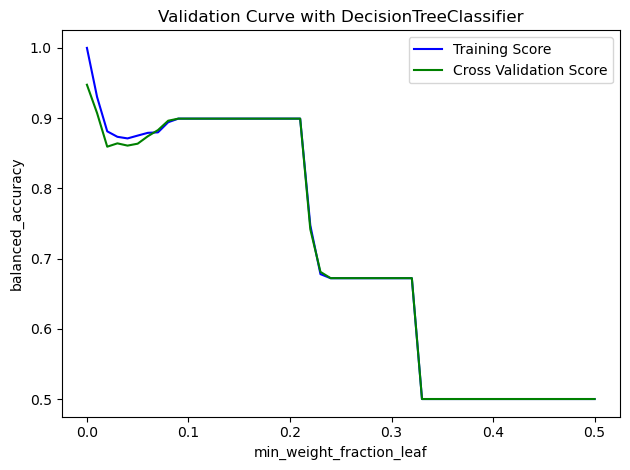

Indices: [99 74 72]
Values: [nan nan nan]


In [77]:
f, train_scores, valid_scores = get_validation_curve(DecisionTreeClassifier(random_state=_random_state), X_train, y_train, "min_weight_fraction_leaf", 0, 1, 0.01, 'balanced_accuracy')
plt.show()
x = np.argsort(valid_scores)[::-1][:3]
print("Indices:",x)

# Getting N maximum values
print("Values:",valid_scores[x])

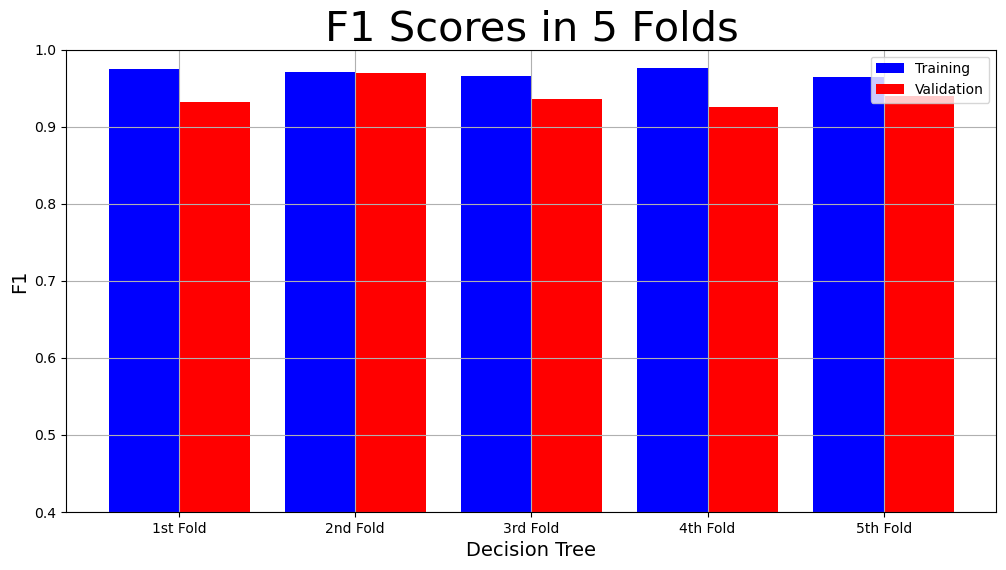

Train F1:  [0.97503671 0.97084548 0.96652111 0.97660819 0.96521739]
Validation F1:  [0.93181818 0.97005988 0.93641618 0.92571429 0.94047619]


In [93]:
# cross validation on all hyperparameters
decision_tree_model = DecisionTreeClassifier(criterion="gini",
                                     max_leaf_nodes=44,
                                     max_depth=29,
                                     random_state=_random_state)
decision_tree_result = cross_validation(decision_tree_model, X_train, y_train, 5)

# Plot F1 Result
model_name = "Decision Tree"
plot_cv_result(model_name,
            "F1",
            "F1 Scores in 5 Folds",
            decision_tree_result["Training F1 scores"],
            decision_tree_result["Validation F1 scores"])

print("Train F1: ", decision_tree_result["Training F1 scores"])
print("Validation F1: ", decision_tree_result["Validation F1 scores"])

## KNN

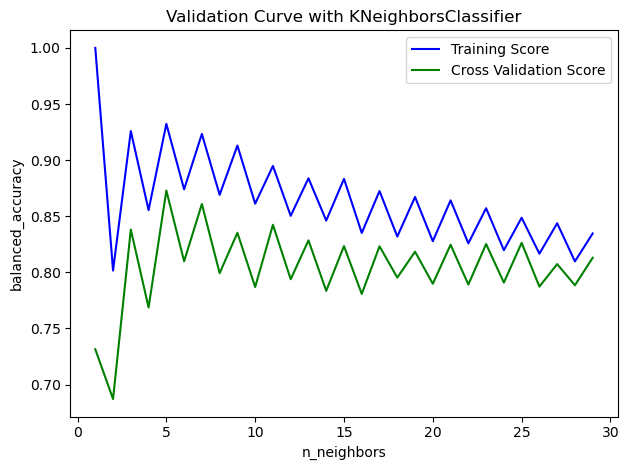

In [29]:
f = get_validation_curve(KNeighborsClassifier(), X_train, y_train, "n_neighbors", 1, 30, 1, 'balanced_accuracy')
plt.show()

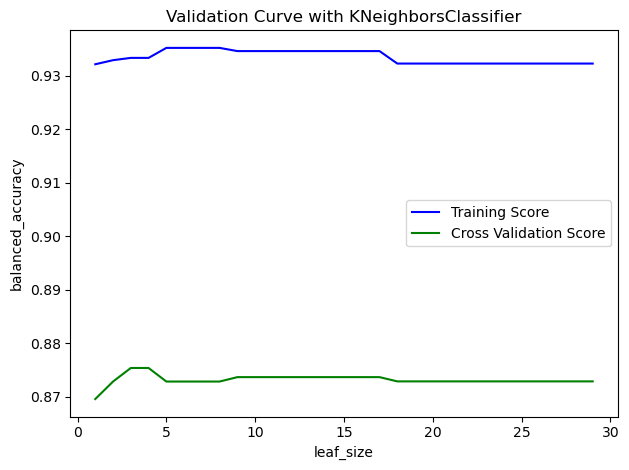

In [31]:
f = get_validation_curve(KNeighborsClassifier(), X_train, y_train, "leaf_size", 1, 30, 1, 'balanced_accuracy')
plt.show()

## Boosting

## Neural Networks

## Support Vector Machines